In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!python -m nltk.downloader punkt

/usr/local/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pip install afinn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install vaderSentiment


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
adj_df = pd.read_csv('adjudicated.csv')
adj_df.head()

,ID,Adjudication,Classification,Text
0,0,Adjudicated,Pessimistic,But the hard truth is that not everyone is sha...
1,1,Adjudicated,Pessimistic,I understand -- I understand the sense of frus...
2,2,Adjudicated,Optimistic,"Now, what should happen when you make a mistak..."
3,3,Adjudicated,Pessimistic,"Mr. Speaker, Members, I rise today really with..."
4,4,Adjudicated,Neutral,"You know, we heard the horror stories about th..."


In [ ]:
train_dev, test = train_test_split(adj_df, test_size=0.2, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.25, random_state=42)

In [ ]:
print("Training set size:", len(train))
print("Development set size:", len(dev))
print("Test set size:", len(test))

Training set size: 300
Development set size: 100
Test set size: 100


In [ ]:
file_path = "splits/test.txt"
test.to_csv(file_path, sep='\t', index=False)
file_path = "splits/train.txt"
train.to_csv(file_path, sep='\t', index=False)
file_path = "splits/dev.txt"
dev.to_csv(file_path, sep='\t', index=False)

In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X, Y

In [ ]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5]:
            self.log_reg = linear_model.LogisticRegression(C = C, penalty='l2', max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

            print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        print(self.log_reg)
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile, feature=binary_bow_featurize):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(feature, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    return simple_classifier

In [ ]:
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"

In [ ]:
#run(trainingFile, devFile, testFile, feature=binary_bow_featurize)

In [ ]:
from afinn import Afinn
def afinn_featurize(text):
    feats = {}
    afinn = Afinn()
    words = nltk.word_tokenize(text)
    for word in words:
        word=word.lower()
        if word not in feats:
          feats[word] = afinn.score(word)
    return feats

In [ ]:
# trainX, trainY=load_data(trainingFile)
# devX, devY=load_data(devFile)
# testX, testY=load_data(testFile)
# afinn_classifier = Classifier(afinn_featurize, trainX, trainY, devX, devY, testX, testY)
# afinn_classifier.train()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_sentiment_scores(text):
    feats = {}
    analyzer = SentimentIntensityAnalyzer()
    words = nltk.word_tokenize(text)
    for word in words:
        word=word.lower()
        if word not in feats:
          feats[word] = analyzer.polarity_scores(word)
    return feats

In [ ]:
# trainX, trainY=load_data(trainingFile)
# devX, devY=load_data(devFile)
# testX, testY=load_data(testFile)
# sentiment_scores_classifier = Classifier(get_sentiment_scores, trainX, trainY, devX, devY, testX, testY)
# sentiment_scores_classifier.train()

In [ ]:
def combiner_function(text):
    all_feats={}
    for feature in [binary_bow_featurize, afinn_featurize]:
        all_feats.update(feature(text))
    return all_feats

In [ ]:
trainX, trainY=load_data(trainingFile)
devX, devY=load_data(devFile)
testX, testY=load_data(testFile)
    
big_classifier = Classifier(combiner_function, trainX, trainY, devX, devY, testX, testY)
big_classifier.train()
accuracy=big_classifier.test()
    
lower, upper=confidence_intervals(accuracy, len(testY), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

big_classifier.printWeights()

C: 0.1, Train accuracy: 0.960, Dev accuracy: 0.535
C: 0.2, Train accuracy: 0.973, Dev accuracy: 0.535
C: 0.3, Train accuracy: 0.980, Dev accuracy: 0.535
C: 0.4, Train accuracy: 0.987, Dev accuracy: 0.515
C: 0.5, Train accuracy: 0.993, Dev accuracy: 0.505
C: 0.6, Train accuracy: 0.993, Dev accuracy: 0.495
C: 0.7, Train accuracy: 0.997, Dev accuracy: 0.505
C: 0.8, Train accuracy: 0.997, Dev accuracy: 0.505
C: 0.9, Train accuracy: 0.997, Dev accuracy: 0.505
C: 1, Train accuracy: 0.997, Dev accuracy: 0.505
C: 5, Train accuracy: 0.997, Dev accuracy: 0.505
LogisticRegression(C=0.1, max_iter=1000)
Test accuracy for best dev model: 0.535, 95% CIs: [0.437 0.632]

Classification	0.023	no
Classification	0.019	war
Classification	0.012	lost
Classification	0.011	killed
Classification	0.011	crisis
Classification	0.010	hard
Classification	0.010	violence
Classification	0.008	failed
Classification	0.008	died
Classification	0.008	problems

Neutral	0.316	crisis
Neutral	0.275	important
Neutral	0.254	proble

### Confusion Matrix

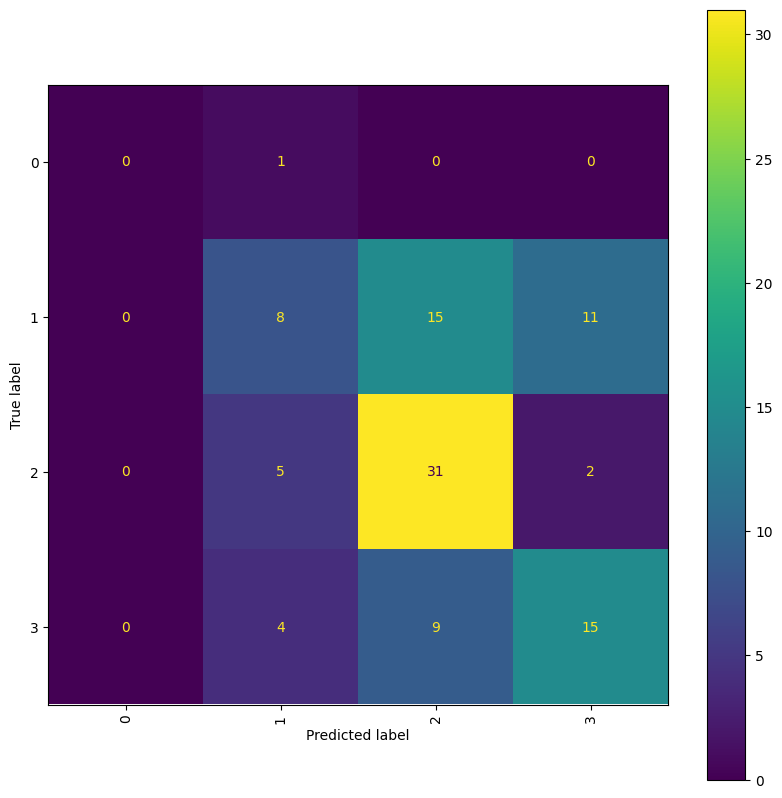

In [ ]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))

    y_pred = classifier.log_reg.predict(classifier.devX)
    cm = confusion_matrix(classifier.devY, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, xticks_rotation="vertical", values_format="d")

    plt.show()

print_confusion(big_classifier)

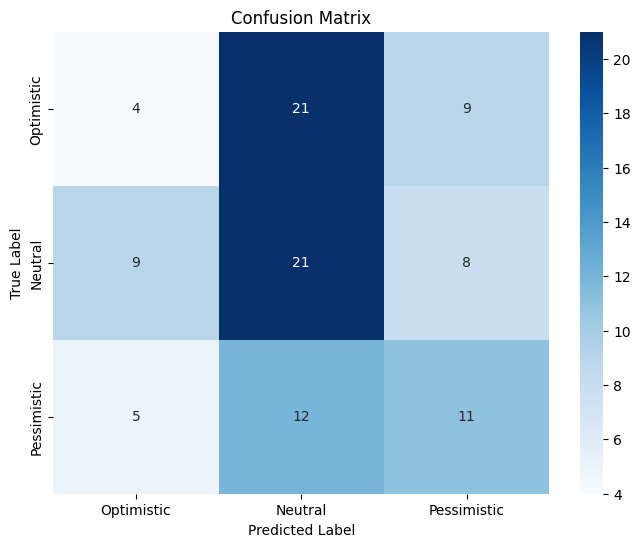

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_labels = ["Optimistic", "Neutral", "Pessimistic"]

y_pred = big_classifier.log_reg.predict(big_classifier.devX)
conf_matrix = confusion_matrix(dev['Classification'], y_pred[:-1])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
dev.groupby("Classification").first()

,ID,Adjudication,Text
Classification,,,
Neutral,120,Adjudicated,It’s been a horrible time to see such death an...
Optimistic,271,Adjudicated,That is why I love this country. And in my own...
Pessimistic,349,Adjudicated,There is a humanitarian and security crisis on...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71a8ee7d-3a4f-4c6b-b37d-002afa827510' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>